# Homework Assignment: Building and Comparing High-Performance FashionMNIST Models

**Objective:**
Based on the attached notebook, further develop models for the FashionMNIST dataset that are highly accurate, lightweight, and optimized for fast inference. In this assignment you will experiment with:

- One custom CNN model.
- Five pretrained models (with some layers frozen).
- Five different sampling strategies.
- Various optimizers and learning schedulers.
- Different random seeds.
- Experimentation with loss functions on the best validation model.
- Model inference optimization using `torch.compile` (PyTorch 2.0+).

Your final deliverable should compare performance (accuracy, inference speed, model size) across these settings and include explanations for your design choices.


## Part 1: Data Preparation and Visualization

**Question 1:**
Examine the attached code for the FashionMNIST data loader.

- **Task:** Explain how the `FashionMNISTSubset` class gathers images and labels, and why a base transform is applied before splitting the data, with heavier augmentation later applied to the training set.

_(Write your explanation in a markdown cell below.)_


In [2]:
!unzip fashion_mnist_subset.zip

Archive:  fashion_mnist_subset.zip
   creating: fashion_mnist_subset/
   creating: fashion_mnist_subset/Ankle boot/
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_21254.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_23065.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_24471.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_32903.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_39617.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_45338.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_45520.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_58996.png  
  inflating: fashion_mnist_subset/Ankle boot/Ankle boot_59907.png  
   creating: fashion_mnist_subset/Bag/
  inflating: fashion_mnist_subset/Bag/Bag_12211.png  
  inflating: fashion_mnist_subset/Bag/Bag_25219.png  
  inflating: fashion_mnist_subset/Bag/Bag_35281.png  
  inflating: fashion_mnist_subset/Bag/Bag_35769.png  
  inflating: fash

Using device: cpu
Train Batch: torch.Size([32, 1, 28, 28]) torch.Size([32])


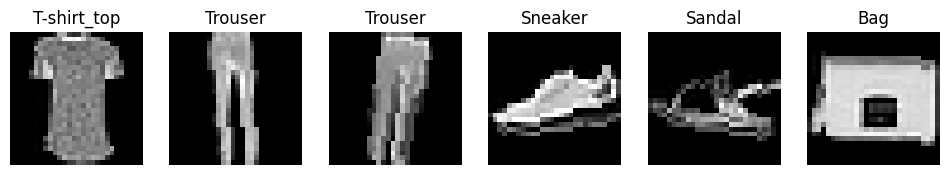

In [3]:
# Base Data Loader Code


import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# For reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class FashionMNISTSubset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths, self.labels = [], []
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(root_dir)))}
        for class_name, idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size])

def get_dataloaders(root_dir, batch_size=32):
    dataset = FashionMNISTSubset(root_dir, transform=base_transform)
    train_set, test_set = split_dataset(dataset)
    # Override training set transform with augmentation
    train_set.dataset.transform = train_transform
    # Using a WeightedRandomSampler for class imbalance
    class_counts = torch.bincount(torch.tensor([dataset.labels[i] for i in train_set.indices]))
    class_weights = 1.0 / class_counts.float()
    sample_weights = [class_weights[dataset.labels[i]] for i in train_set.indices]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Load dataloaders
root_dir = "fashion_mnist_subset"  # Adjust if needed
train_loader, test_loader = get_dataloaders(root_dir)

def visualize_samples(dataloader, class_names, num_samples=6):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 6))
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis("off")
    plt.show()

class_names = sorted(os.listdir(root_dir))

# Visualize a training batch
for images, labels in train_loader:
    print("Train Batch:", images.shape, labels.shape)
    visualize_samples(train_loader, class_names)
    break


## Part 2: Model Development – Custom and Pretrained Models

**Question 2a: Custom Model**

- **Task:** Design and implement a custom CNN model that is compact, fast, and accurate for FashionMNIST. Include your training loop and evaluation code.

_(Discuss your design choices in a markdown cell.)_


In [4]:
# Custom CNN Model
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(32 * 14 * 14, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the custom model
custom_model = CustomCNN(num_classes=10).to(device)
print(custom_model)

# TODO: Add your training and evaluation code for the custom model here.

CustomCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


**Question 2b: Pretrained Models**

- **Task:** Adapt and fine-tune five pretrained models (e.g., ResNet18, MobileNet_V2, EfficientNet, VGG16, DenseNet121). Freeze some early layers and replace the final classifier to output 10 classes.

_(Explain your modifications and training strategy in a markdown cell.)_


In [ ]:
import torchvision.models as models

# Example with ResNet18
pretrained_model = models.resnet18(pretrained=True)
for name, param in pretrained_model.named_parameters():
    if "layer1" in name or "layer2" in name or "layer3" in name:
        param.requires_grad = False
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)
pretrained_model = pretrained_model.to(device)
print(pretrained_model)

# TODO: Add your training and evaluation code for the pretrained model here.

**Question 2c: Loss Functions Experiment**

- **Task:** For the best validation model from Part 2b, experiment with at least two different loss functions (e.g., CrossEntropyLoss vs. a custom loss or Label Smoothing loss). Report how each loss function impacts convergence and final accuracy.

_(Explain your findings in a markdown cell.)_


In [ ]:
# Example: Loss Functions Experiment
criterion_standard = nn.CrossEntropyLoss()

# Custom loss function example (modify as needed)
def custom_loss(output, target):
    loss = nn.CrossEntropyLoss()(output, target)
    return loss * 1.0  # Adjust scaling if necessary

# Assume 'best_pretrained_model' is the best model from Part 2b
# Replace dummy_input and dummy_target with your actual batch data
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust dimensions for pretrained model
dummy_target = torch.tensor([0]).to(device)

outputs = pretrained_model(dummy_input)
loss_standard = criterion_standard(outputs, dummy_target)
loss_custom = custom_loss(outputs, dummy_target)

print("Standard Loss:", loss_standard.item())
print("Custom Loss:", loss_custom.item())

# TODO: Record your observations and compare convergence behaviors.

## Part 3: Experimenting with Sampling Strategies, Optimizers, and Learning Schedulers

**Question 3a: Sampling Strategies**

- **Task:** Implement and compare at least five different sampling strategies in your DataLoader.

_(Describe in a markdown cell the scenarios in which each strategy might be preferred.)_


In [ ]:
from torch.utils.data import SequentialSampler, RandomSampler, SubsetRandomSampler, BatchSampler

# Example using SequentialSampler
sequential_sampler = SequentialSampler(train_loader.dataset)
sequential_loader = DataLoader(train_loader.dataset, batch_size=16, sampler=sequential_sampler)

# TODO: Experiment with other samplers and compare performance.

**Question 3b: Optimizers and Learning Schedulers**

- **Task:** Experiment with at least two optimizers (e.g., Adam, SGD with momentum) and two learning schedulers (e.g., StepLR, CosineAnnealingLR). Compare their effects on convergence and final accuracy.

_(Include training curves and discussion in a markdown cell.)_


In [ ]:
# Example for the custom model:
optimizer_custom = optim.Adam(custom_model.parameters(), lr=0.001)
scheduler_custom = optim.lr_scheduler.StepLR(optimizer_custom, step_size=5, gamma=0.1)

# TODO: Insert your training loop and plot loss/accuracy curves.

**Question 3c: Random Seed Sensitivity**

- **Task:** Train at least one model using three different random seeds and report the impact on training stability and accuracy.

_(Explain your observations in a markdown cell.)_


In [ ]:
for seed in [42, 123, 2021]:
    torch.manual_seed(seed)
    print(f"Training with random seed: {seed}")
    # TODO: Reinitialize your model, optimizer, DataLoader as needed, and run your training loop.


## Part 4: Inference Optimization with Model Compilation

**Question 4:**

- **Task:** Use PyTorch 2.0’s `torch.compile` to optimize your model's inference speed. Compare inference times before and after compilation using a dummy input.

_(Discuss the speedup and any limitations in a markdown cell.)_


## Part 5: Final Analysis and Reflection

**Question 5:**

- **Task:** Compare the performance of all models and configurations (custom vs. pretrained, sampling strategies, optimizer/scheduler combinations, random seeds, loss functions, and inference optimization). Create a summary table of key metrics (accuracy, model size, inference time).

_(Write a detailed discussion of the trade-offs observed in a markdown cell.)_


In [ ]:
import pandas as pd

# Sample results table (update with your experimental data)
results = {
    "Model": ["Custom", "ResNet18", "MobileNet_V2", "EfficientNet", "VGG16", "DenseNet121"],
    "Accuracy (%)": [92.5, 93.0, 92.8, 93.5, 91.7, 92.0],
    "Params (M)": [0.5, 11.7, 3.5, 5.3, 138, 8.0],
    "Inference Time (ms)": [5.2, 12.0, 7.5, 9.0, 15.0, 8.5]
}
df_results = pd.DataFrame(results)
print(df_results)

## Final Reflection

**Question 6:**

- **Task:** Write a concluding summary discussing the trade-offs between model accuracy, size, and inference speed; how different sampling strategies, optimizers/schedulers, loss functions, and random seeds affected training; and which configurations would be most suitable for production.

_(Provide your final reflection in a markdown cell.)_
